**Ensure all other Jupyter kernels are stopped when running GPU-accelerated labs.**

**Labs can also run on your laptop CPU, albeit at slightly reduced speed (but less than you might expect).**


**If performed on laptop, charger must be connected (4x slower if on battery)**

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras import layers

from etils import ecolab # ? Collapsible text output.

np.random.seed(1671) # Reproducibility, same seed used in lab sheet.

print("TensorFlow version:", tf.__version__)
print("Detected devices:", tf.config.list_physical_devices())
# assert tf.test.is_built_with_cuda() 
# ? Throws an error if CUDA isn't working properly (GPU disconnected).

TensorFlow version: 2.11.1
Detected devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
(trainData, trainTargets), (testData, testTargets) = boston_housing.load_data()

In [4]:
mean = trainData.mean(axis=0)
trainData -= mean
std = trainData.std(axis=0)
trainData /= std
testData -= mean
testData /= std

In [5]:
def buildModel():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation = "relu", 
                           input_shape = (trainData.shape[1],)))
    model.add(layers.Dense(64, activation = "relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
    return model

In [ ]:
# Will be appended to in order to hold all model metrics.
allScores = []

def kFold(k, numEpochs, trainData = trainData):
    numValSamples = len(trainData) // k
    
    for i in range(k):
        print("Processing fold", i + 1)
        valData = trainData[i * numValSamples: (i + 1) * numValSamples] 
        valTargets = trainTargets[i * numValSamples: (i + 1) * numValSamples]
        partialTrainData = np.concatenate(
            [trainData[: i * numValSamples], 
             trainData[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        partialTrainTargets = np.concatenate(
            [trainTargets[: i * numValSamples], 
             trainTargets[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        
        model = buildModel()
        
        model.fit(partialTrainData, partialTrainTargets, epochs = numEpochs,
                  batch_size = 1, verbose = 1)
        
        valMSE, valMAE = model.evaluate(valData, valTargets)
        allScores.append(valMAE)

In [ ]:

# ? Collapses output so that this notebook can be scrolled much easier.
with ecolab.collapse():
    kFold(k = 4, numEpochs = 100)

Accordion(children=(Output(),), titles=('',))

In [7]:
for i, score in enumerate(allScores):
    print(f"Fold {i} MAE: {score}")
    
print(f"Overall MAE: {np.mean(allScores)}")

Fold 0 MAE: 1.9313733577728271
Fold 1 MAE: 2.923966884613037
Fold 2 MAE: 2.489597797393799
Fold 3 MAE: 2.3872668743133545
Overall MAE: 2.4330512285232544


In [ ]:

# ? The KFold function created earlier can be updated to track per-epoch scores.
allMAEHistories = []

# ? Also refreshing the allScores.
allScores = []

def kFold(k, numEpochs, trainData = trainData):
    numValSamples = len(trainData) // k
    
    for i in range(k):
        print("Processing fold", i + 1)
        valData = trainData[i * numValSamples: (i + 1) * numValSamples] 
        valTargets = trainTargets[i * numValSamples: (i + 1) * numValSamples]
        partialTrainData = np.concatenate(
            [trainData[: i * numValSamples], 
             trainData[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        partialTrainTargets = np.concatenate(
            [trainTargets[: i * numValSamples], 
             trainTargets[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        
        model = buildModel()
        
        # ! New functionality below. Model now uses validation data and 
        # ! tracks MAEs across all epochs, appending them to allMAEHistories list.
        history = model.fit(partialTrainData, partialTrainTargets, 
                            validation_data = (valData, valTargets),
                            epochs = numEpochs, batch_size = 1, verbose = 1)
        
        maeHistory = history.history["val_mae"]
        allMAEHistories.append(maeHistory)
        
        # ? Also get the per-fold scores as before.
        valMSE, valMAE = model.evaluate(valData, valTargets)
        allScores.append(valMAE)
        
    averageMAEHistory = [np.mean([x[i] # ? Get the mean
                        for x in allMAEHistories]) # ? of all MAEs
                        for i in range(numEpochs)] # ? across all epochs.
    
    plt.plot(range(1, len(averageMAEHistory) + 1), averageMAEHistory)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

In [18]:

# ? Collapses output so that this notebook can be scrolled much easier.
with ecolab.collapse():
    kFold(k = 4, numEpochs = 3)
    # ? 200 epochs was specified in the lab sheet but it takes approx 5min30sec.

Accordion(children=(Output(),), titles=('',))

The graph will look like a very sharp decrease in loss followed by heavy fluctuations across epochs (up/down/up/down etc.)

In [ ]:
for i, score in enumerate(allScores):
    print(f"Fold {i} average MAE: {score}")
    
print(f"Average of all folds: {np.mean(allScores)}")



Fold 0 average MAE: 2.4219443798065186
Fold 1 average MAE: 2.9383139610290527
Fold 2 average MAE: 2.779630661010742
Fold 3 average MAE: 2.814145565032959
Average of all folds: 2.738508641719818


In [12]:

# ! These last cells were rushed due to time running out in the lab.

# Let’s use k-fold cross-validation and get the loss error for
# the training and validation sets for visualisation
allMAEHistories = []
allMAEHistoriesTrain = [] # this is for the training curve

def kFold(k, numEpochs, trainData = trainData):
    numValSamples = len(trainData) // k
    
    for i in range(k):
        print("Processing fold", i + 1)
        valData = trainData[i * numValSamples: (i + 1) * numValSamples] 
        valTargets = trainTargets[i * numValSamples: (i + 1) * numValSamples]
        partialTrainData = np.concatenate(
            [trainData[: i * numValSamples], 
             trainData[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        partialTrainTargets = np.concatenate(
            [trainTargets[: i * numValSamples], 
             trainTargets[(i + 1) * numValSamples:]],
            axis = 0
        ) 
        
        model = buildModel()
        
        history = model.fit(partialTrainData, partialTrainTargets, 
                            validation_data = (valData, valTargets),
                            epochs = numEpochs, batch_size = 1, verbose = 1)
        
        maeHistory = history.history["val_mae"]
        allMAEHistories.append(maeHistory)
        
        maeTrainHistory = history.history["loss"]
        allMAEHistoriesTrain.append(maeTrainHistory)
        
        
    averageMAEHistory = [np.mean([x[i] 
                            for x in allMAEHistories]) 
                            for i in range(numEpochs)]
    averageMAEHistoryTrain = [np.mean([x[i] 
                            for x in allMAEHistoriesTrain]) 
                            for i in range(numEpochs)]
    
    plt.plot(range(1, len(averageMAEHistory) + 1),
            averageMAEHistory, 'r', label = 'validation loss')
    plt.plot(range(1, len(averageMAEHistoryTrain) + 1),
            averageMAEHistoryTrain, 'b', label = 'training loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Processing fold 1
Epoch 1/25
303/303 [==============================] - 1s 2ms/step - loss: 205.6472 - mae: 10.8201 - val_loss: 35.0808 - val_mae: 3.9436
Epoch 2/25
303/303 [==============================] - 0s 1ms/step - loss: 28.5402 - mae: 3.5877 - val_loss: 21.8692 - val_mae: 2.9339
Epoch 3/25
303/303 [==============================] - 0s 1ms/step - loss: 20.0181 - mae: 3.0289 - val_loss: 16.8216 - val_mae: 2.5931
Epoch 4/25
303/303 [==============================] - 0s 1ms/step - loss: 16.6317 - mae: 2.7768 - val_loss: 15.5566 - val_mae: 2.4647
Epoch 5/25
303/303 [==============================] - 1s 2ms/step - loss: 14.6760 - mae: 2.5878 - val_loss: 17.1614 - val_mae: 2.8130
Epoch 6/25
303/303 [==============================] - 1s 2ms/step - loss: 14.0933 - mae: 2.4604 - val_loss: 11.2631 - val_mae: 2.3285
Epoch 7/25
303/303 [==============================] - 0s 1ms/step - loss: 13.5082 - mae: 2.4435 - val_loss: 11.2712 - val_mae: 2.4261
Epoch 8/25
303/303 [======================

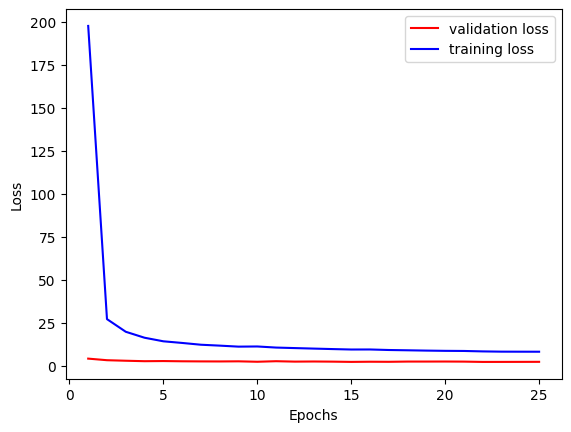

In [13]:

# ? It's possible that there's been an error if any cell is run twice.
# ? Attempted fix is resetting arrays.
allMAEHistories = []
allMAEHistoriesTrain = []

kFold(k = 4, numEpochs = 25)
# ? 200 epochs was specified in the lab sheet but it takes approx 5min30sec.